In [1]:
import pandas as pd
import sklearn
import seaborn as sns
import numpy as np
from numpy import nan
import re
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from pycaret.classification import *
from sklearn.model_selection import GridSearchCV
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

In [2]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')

In [3]:
df=pd.concat([train,test])

In [4]:
# 서울시 따릉이 데이터
# https://data.seoul.go.kr/dataList/OA-21229/F/1/datasetView.do
# 서울시 따릉이 10월 1일 이용량 : 260152

In [5]:
# 따릉이 대여소 수 : 2719
# 대여소별 시간당 평균 이용량
260152/2719/24

3.9866372440848354

In [6]:
# 제공된 데이터에서 평균 이용량
df['count'].mean()

108.56339958875942

In [7]:
# 대여소 27개 정도의 이용량 합계가 아닌가.. 하는 추측   -> 결론적으로 무의미했음
(df['count'].mean())/(260152/2719/24)

27.23182294798458

In [8]:
for i in range(24):
    print(f'[{i}] : {df.hour_bef_temperature[df.hour==i].mean()}')
# hour가 7일때 가장 낮음    -> 평균적으로 hour가 7일때 일최저기온
# hour가 16일때 가장 높음   -> 평균적으로 hour가 16일때 일최고기온

[0] : 17.012359550561797
[1] : 16.407692307692304
[2] : 16.006593406593407
[3] : 15.614285714285712
[4] : 15.260439560439558
[5] : 14.91666666666667
[6] : 14.640659340659342
[7] : 14.498901098901097
[8] : 14.989010989010989
[9] : 16.608791208791207
[10] : 18.365934065934066
[11] : 20.02747252747253
[12] : 21.426373626373625
[13] : 22.642222222222223
[14] : 23.291208791208792
[15] : 23.819780219780213
[16] : 24.048314606741574
[17] : 23.638202247191014
[18] : 22.908988764044942
[19] : 21.76888888888889
[20] : 20.37142857142857
[21] : 19.16741573033708
[22] : 18.193406593406593
[23] : 17.563736263736264


In [9]:
# 월별 최저,최고 기온 데이터
# https://data.kma.go.kr/stcs/grnd/grndTaList.do?pgmNo=70

(array([ 4.,  3.,  1., 16.,  7., 13., 10., 16., 14.,  5.]),
 array([11.6 , 13.74, 15.88, 18.02, 20.16, 22.3 , 24.44, 26.58, 28.72,
        30.86, 33.  ]),
 <BarContainer object of 10 artists>)

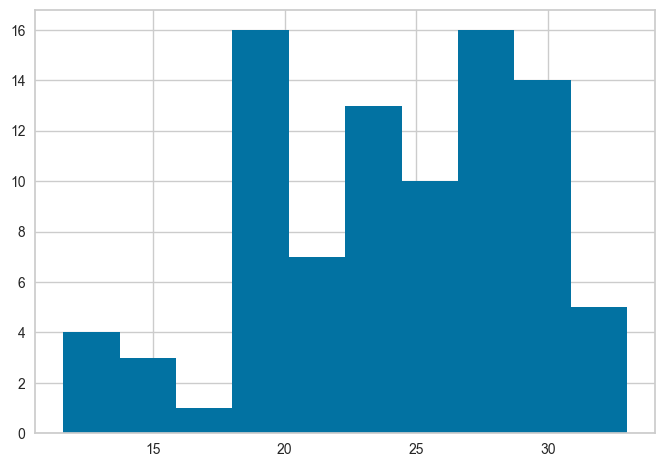

In [10]:
# 일최고기온 4~33   -> 여러 계절동안 측정한 데이터임
plt.hist(df.hour_bef_temperature[df.hour==16])

(array([ 2.,  2.,  7., 12.,  8., 13., 16., 12.,  8., 11.]),
 array([ 3.1 ,  5.04,  6.98,  8.92, 10.86, 12.8 , 14.74, 16.68, 18.62,
        20.56, 22.5 ]),
 <BarContainer object of 10 artists>)

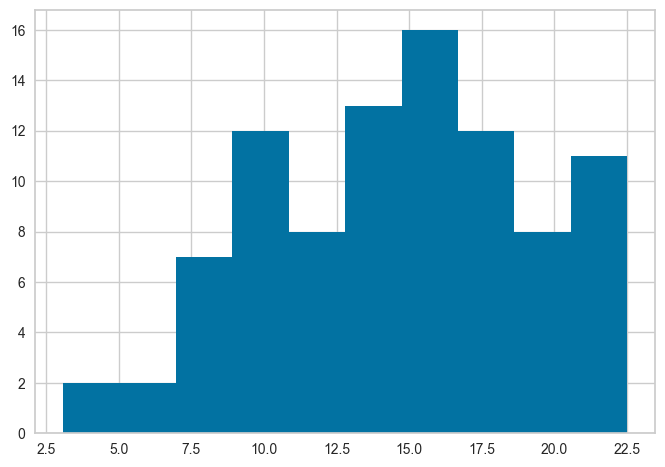

In [11]:
# 일최저기온 히스토그램
plt.hist(df.hour_bef_temperature[df.hour==7])
# 일최저기온 2~22 사이임    -> 겨울은 포함되지 않았다   -> 봄,여름 or 여름,가을 or 봄,여름,가을

In [12]:
# 여름(6,7,8월) 일최고기온은 평균적으로 27도 이상임
# 일최고기온(hour=16) 전체 중에 27도 넘는게 몇%인지 확인    -> 대략 50% -> 봄,여름 or 봄,가을
#                                                         -> 대략 33% -> 봄,여름,가을

In [13]:
# 일최고기온(hour=16)의 총 갯수 : 89
df[df.hour==16].shape[0]

89

In [14]:
# 27도 이상인 데이터 수 : 29
df[(df.hour==16)&(df.hour_bef_temperature>27)].shape[0]

29

In [15]:
# 대략 33%나옴  -> 즉 봄,여름,가을 동안 측정한 데이터임
29/89

0.3258426966292135

In [16]:
df.isna().sum()

id                          0
hour                        0
hour_bef_temperature        3
hour_bef_precipitation      3
hour_bef_windspeed         10
hour_bef_humidity           3
hour_bef_visibility         3
hour_bef_ozone            111
hour_bef_pm10             127
hour_bef_pm2.5            153
count                     715
dtype: int64

In [17]:
df[df.hour_bef_temperature.isna()]
# 가진 정보 거의 없음

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
934,1420,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39.0
1035,1553,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
653,1943,19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
# 인덱스 기준으로 지우려는데 합쳐진 데이터 프레임이라 인덱스 겹치는거 있음
df[df.index==653]

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
653,1000,5,11.8,0.0,2.5,21.0,1014.0,0.042,205.0,18.0,6.0
653,1943,19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
df.sort_values(by='id',inplace=True)

In [20]:
# 인덱스 재설정
df.reset_index(drop=True,inplace=True)

In [21]:
df[(df.id==1420)|(df.id==1553)|(df.id==1943)]

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
1415,1420,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39.0
1548,1553,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1937,1943,19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
# id=1943인 행은 test데이터임...
# id=1943, hour=19 나머지는 다 nan
# 일단 다 삭제하고 id=1943만 나중에 나머지 데이터 결측치 처리 다 하고나서 hour=19인 데이터의 평균으로 채우던지 해야될듯
df.drop(index=[1415,1548,1937],axis=0,inplace=True)

In [23]:
# hour, temp 기준으로 정렬해서 위아래값 평균으로 windspeed 대체
df.sort_values(by=['hour','hour_bef_temperature'],inplace=True)
df.hour_bef_windspeed.interpolate(inplace=True)

In [24]:
df.isna().sum()

id                          0
hour                        0
hour_bef_temperature        0
hour_bef_precipitation      0
hour_bef_windspeed          0
hour_bef_humidity           0
hour_bef_visibility         0
hour_bef_ozone            108
hour_bef_pm10             124
hour_bef_pm2.5            150
count                     714
dtype: int64

In [25]:
# 시간, 기온순으로 정렬
df.sort_values(by=['hour','hour_bef_temperature'],inplace=True)

In [26]:
# 빈 데이터 프레임
spring=df[df.hour==24]
summer=df[df.hour==24]
fall=df[df.hour==24]
other=df[df.hour==24]

In [27]:
# 시간별로 기온 상위33%만 summer 데이터
# 나머지는 기온으로 구분안되니 일단 합쳐서 other에 저장
for i in range(0,24):
    tmp=df[df.hour==i].iloc[:round(df[df.hour==i].shape[0]/3),]
    tmp1=df[df.hour==i].iloc[round(df[df.hour==i].shape[0]/3):,]
    summer=pd.concat([summer,tmp])
    other=pd.concat([other,tmp1])

In [28]:
# 잘 나눠졌는지 확인
df.shape[0]==summer.shape[0]+other.shape[0]

True

In [29]:
summer.isna().sum()

id                         0
hour                       0
hour_bef_temperature       0
hour_bef_precipitation     0
hour_bef_windspeed         0
hour_bef_humidity          0
hour_bef_visibility        0
hour_bef_ozone            33
hour_bef_pm10             43
hour_bef_pm2.5            67
count                     12
dtype: int64

In [30]:
# https://cleanair.seoul.go.kr/statistics/monthAverage
# 마포구 월별 오존, 미세먼지 데이터
# 여름 평균 오존,미세먼지,초미세먼지 : 0.036,20.67 ,12.67

In [31]:
summer.hour_bef_ozone[summer.hour_bef_ozone.isna()]=0.036
summer.hour_bef_pm10[summer.hour_bef_pm10.isna()]=21
summer['hour_bef_pm2.5'][summer['hour_bef_pm2.5'].isna()]=13

In [32]:
# https://cleanair.seoul.go.kr/statistics/monthAverage
# 마포구 월별 오존, 미세먼지 데이터
# -> 봄이 가을보다 오존, 미세먼지 높음
# -> 오존, 미세먼지 기준으로 봄, 가을 나누고 싶음

In [33]:
other.shape[0]

1451

In [34]:
# 봄,가을 데이터는 1450중 75개,81,83 결측
other.isna().sum()

id                          0
hour                        0
hour_bef_temperature        0
hour_bef_precipitation      0
hour_bef_windspeed          0
hour_bef_humidity           0
hour_bef_visibility         0
hour_bef_ozone             75
hour_bef_pm10              81
hour_bef_pm2.5             83
count                     702
dtype: int64

In [35]:
other.hour_bef_ozone.mean(),other.hour_bef_pm10.mean(),other['hour_bef_pm2.5'].mean()

(0.041644622093023255, 46.65985401459854, 27.507309941520468)

In [36]:
# 결측치 일단은 other의 평균으로 대체
other.hour_bef_ozone[other.hour_bef_ozone.isna()]=0.0416
other.hour_bef_pm10[other.hour_bef_pm10.isna()]=47
other['hour_bef_pm2.5'][other['hour_bef_pm2.5'].isna()]=28

In [37]:
# 봄,가을을  기준으로 정렬해서 나누기
other.sort_values(by=['hour','hour_bef_ozone','hour_bef_pm10'],inplace=True)

In [38]:
for i in range(0,24):
    tmp=other[other.hour==i].iloc[:round(other[other.hour==i].shape[0]/2),]
    tmp1=other[other.hour==i].iloc[round(other[other.hour==i].shape[0]/2):,]
    spring=pd.concat([spring,tmp1])
    fall=pd.concat([fall,tmp])

In [39]:
# 계절 별로 겹치지않고 잘 나눠졌는지 확인
df.shape[0]==summer.shape[0]+fall.shape[0]+spring.shape[0]

True

In [40]:
# 위에서 other의 평균으로 대체 해주었던 데이터들 각각 봄,가을의 평균으로 다시 대체
# 봄 오존,미세,초미세 : 0.0393, 37.67, 18
# 가을 오존,미세,초미세 : 0.023, 26.67, 17
summer.hour_bef_ozone[summer.hour_bef_ozone==0.0416]=0.0393
summer.hour_bef_pm10[summer.hour_bef_pm10==47]=38
summer['hour_bef_pm2.5'][summer['hour_bef_pm2.5']==28]=18
fall.hour_bef_ozone[fall.hour_bef_ozone==0.0416]=0.023
fall.hour_bef_pm10[fall.hour_bef_pm10==47]=27
fall['hour_bef_pm2.5'][fall['hour_bef_pm2.5']==28]=17

In [41]:
im_df=pd.concat([spring,summer,fall])

In [42]:
im_df.reset_index(drop=True,inplace=True)

In [43]:
im_df.shape

(2171, 11)

In [44]:
im_df.tail()

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
2166,327,23,25.1,0.0,1.5,53.0,2000.0,0.031,30.0,19.0,NaN
2167,869,23,18.0,0.0,1.4,36.0,1051.0,0.031,166.0,36.0,131.0
2168,348,23,17.5,0.0,3.9,83.0,1884.0,0.032,26.0,20.0,NaN
2169,652,23,25.6,0.0,3.9,42.0,2000.0,0.032,42.0,32.0,NaN
2170,937,23,22.1,0.0,1.5,80.0,1563.0,0.033,21.0,19.0,NaN


In [45]:
# 초반에 지운 test데이터 다시 추가
im_df.loc[2171]=[1943,19,im_df.hour_bef_temperature.mean(), round(im_df.hour_bef_precipitation.mean()),
                 im_df.hour_bef_windspeed.mean(), round(im_df.hour_bef_humidity.mean()), round(im_df.hour_bef_visibility.mean()),
                 im_df.hour_bef_ozone.mean(), round(im_df.hour_bef_pm10.mean()), round(im_df['hour_bef_pm2.5'].mean()), np.nan]

In [46]:
im_df.tail()

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
2167,869.0,23.0,18.000000,0.0,1.400000,36.0,1051.0,0.031000,166.0,36.0,131.0
2168,348.0,23.0,17.500000,0.0,3.900000,83.0,1884.0,0.032000,26.0,20.0,NaN
2169,652.0,23.0,25.600000,0.0,3.900000,42.0,2000.0,0.032000,42.0,32.0,NaN
2170,937.0,23.0,22.100000,0.0,1.500000,80.0,1563.0,0.033000,21.0,19.0,NaN
2171,1943.0,19.0,18.870244,0.0,2.450161,54.0,1390.0,0.039493,49.0,28.0,NaN


In [47]:
im_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2172 entries, 0 to 2171
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      2172 non-null   float64
 1   hour                    2172 non-null   float64
 2   hour_bef_temperature    2172 non-null   float64
 3   hour_bef_precipitation  2172 non-null   float64
 4   hour_bef_windspeed      2172 non-null   float64
 5   hour_bef_humidity       2172 non-null   float64
 6   hour_bef_visibility     2172 non-null   float64
 7   hour_bef_ozone          2172 non-null   float64
 8   hour_bef_pm10           2172 non-null   float64
 9   hour_bef_pm2.5          2172 non-null   float64
 10  count                   1457 non-null   float64
dtypes: float64(11)
memory usage: 203.6 KB


In [48]:
x_train=pd.merge(train[['id']],im_df,how='inner')

In [49]:
x_test=pd.merge(test[['id']],im_df,how='inner')

In [50]:
# x_train.drop('id',axis=1,inplace=True)
# x_test.drop('id',axis=1,inplace=True)
x_test.drop('count',axis=1,inplace=True)
x_test.hour_bef_precipitation=test.hour_bef_precipitation.astype('category')
x_train.hour_bef_precipitation=train.hour_bef_precipitation.astype('category')
x_train.hour=train.hour.astype('category')
x_test.hour=test.hour.astype('category')
# train.hour_bef_humidity=train.hour_bef_humidity.astype('int64')
# test.hour_bef_humidity=test.hour_bef_humidity.astype('int64')
# train.hour_bef_visibility=train.hour_bef_visibility.astype('int64')
# test.hour_bef_visibility=test.hour_bef_visibility.astype('int64')
# train.hour_bef_pm10=train.hour_bef_pm10.astype('int64')
# test.hour_bef_pm10=test.hour_bef_pm10.astype('int64')
# train['hour_bef_pm2.5']=train['hour_bef_pm2.5'].astype('int64')
# test['hour_bef_pm2.5']=test['hour_bef_pm2.5'].astype('int64')
# train['count']=train['count'].astype('int64')

In [51]:
y_train=x_train[['count']]
x_train.drop('count',axis=1,inplace=True)

In [52]:
x_train.hour_bef_precipitation[x_train.hour_bef_precipitation.isna()]=0

In [53]:
x_test.hour_bef_precipitation[x_test.hour_bef_precipitation.isna()]=0

In [54]:
x_test.isna().sum()

id                        0
hour                      0
hour_bef_temperature      0
hour_bef_precipitation    0
hour_bef_windspeed        0
hour_bef_humidity         0
hour_bef_visibility       0
hour_bef_ozone            0
hour_bef_pm10             0
hour_bef_pm2.5            0
dtype: int64

In [55]:
x_train.isna().sum()

id                        0
hour                      0
hour_bef_temperature      0
hour_bef_precipitation    0
hour_bef_windspeed        0
hour_bef_humidity         0
hour_bef_visibility       0
hour_bef_ozone            0
hour_bef_pm10             0
hour_bef_pm2.5            0
dtype: int64

In [56]:
rfr = RandomForestRegressor(n_estimators=100, random_state=42)

# 모델 학습
rfr.fit(x_train, y_train)

# 테스트 데이터로 예측
y_pred = rfr.predict(x_test)

In [57]:
subb=pd.read_csv('submission.csv')

In [58]:
subb['count']=y_pred

In [59]:
subb.to_csv('따릉1.csv',index=False)

In [60]:
# ------------------------------------ 따릉2

In [61]:
im_df.head()

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
0,1578.0,0.0,18.3,0.0,2.6,47.0,2000.0,0.033,49.0,32.0,107.0
1,984.0,0.0,14.9,0.0,2.4,35.0,2000.0,0.034,55.0,20.0,68.0
2,559.0,0.0,15.4,0.0,2.4,41.0,2000.0,0.035,26.0,11.0,80.0
3,825.0,0.0,14.8,1.0,2.8,97.0,356.0,0.036,12.0,11.0,NaN
4,447.0,0.0,24.2,0.0,1.2,70.0,1050.0,0.036,27.0,22.0,NaN


In [62]:
# IterativeImputer 결측치 없애기
colnames=im_df.columns[:]
df3=im_df.iloc[:,:]
imputer = IterativeImputer(random_state=2023)
df3 = imputer.fit_transform(df3)
df3 = pd.DataFrame(df3)
df3.columns = colnames

In [63]:
test2=pd.merge(test[['id']],df3,how='inner')

In [64]:
test2.head()

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
0,0,7.0,20.7,0.0,1.3,62.0,954.0,0.041,44.0,27.0,102.819497
1,1,17.0,30.0,0.0,5.4,33.0,1590.0,0.061,49.0,36.0,241.115551
2,2,13.0,19.0,1.0,2.1,95.0,193.0,0.020,36.0,18.0,69.510939
3,4,6.0,22.5,0.0,2.5,60.0,1185.0,0.027,52.0,38.0,115.909452
4,5,22.0,14.6,1.0,3.4,93.0,218.0,0.041,18.0,15.0,101.753974


In [65]:
subb=pd.read_csv('submission.csv')
subb['count']=test2['count']
subb.to_csv('따릉2.csv',index=False)